<a href="https://colab.research.google.com/github/Frostofree/CVIT_Worskshop/blob/main/Day6/Session2/Task1/Copy_of_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning by translating CLIP embeddings to GPT-2

In [1]:
#@title Installing HuggingFace Transformers and CLIP (OpenAI)
!pip install transformers
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 109.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-w5kv3k96
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-w5kv3k96
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=487740e9e43a2b0b5749cb6aa2ec3f6215916595373e8ab9535115942cc8eaa7
  S

In [2]:
def download_file(file_id, file_dst):
    !gdown --id $file_id -O $file_dst

In [3]:
#@title Imports

import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image 

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_wieghts.pt')


In [4]:
#@title Model

class MLP(nn.Module):

    def __init__(self, sizes, bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class ClipCaptionModel(nn.Module):

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))

In [5]:
#@title Caption prediction

def generate_caption(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [6]:
def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts

In [7]:
#@title Choose pretrained model - COCO or Coneptual captions


pretrained_model = 'Conceptual captions'  # @param ['COCO', 'Conceptual captions']

if pretrained_model == 'Conceptual captions':
    download_file("14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT", model_path)
else:
    download_file("1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX", model_path)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT
To: /pretrained_models/model_wieghts.pt
100% 636M/636M [00:15<00:00, 40.0MB/s]


In [8]:
#@title GPU/CPU


use_gpu = True #@param {type:"boolean"}  

if use_gpu and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    torch.device('cpu')

In [9]:
#@title CLIP model + GPT2 tokenizer

clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 312MiB/s]


In [10]:
#@title Load model weights


prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) 

model = model.eval() 
model = model.to(device)

In [48]:
#@title Upload Image


uploaded = files.upload()

if not uploaded:
  UPLOADED_FILE = ''
elif len(uploaded) == 1:
  UPLOADED_FILE = list(uploaded.keys())[0]
else:
  raise AssertionError('Please upload one image at a time')


Saving WhatsApp Image 2023-05-27 at 4.11.33 PM.jpeg to WhatsApp Image 2023-05-27 at 4.11.33 PM.jpeg


Saving WhatsApp Image 2023-05-27 at 4.11.33 PM.jpeg to WhatsApp Image 2023-05-27 at 4.11.33 PM (1).jpeg


In [37]:
# #@title Or download random samples form COCO test set (Karpathy et al. split)

# IMAGE_NAME = '483108'  # @param ['562207', '579664', '334321', '483108', '386164', '354533']

# name_ = "COCO_val2014_000000" + IMAGE_NAME + ".jpg"
# images_path = os.path.join(os.path.dirname(current_directory), "images")
# os.makedirs(images_path, exist_ok=True)
# UPLOADED_FILE = os.path.join(images_path, name_)

# if not os.path.isfile(UPLOADED_FILE):
#   download_path = os.path.join(images_path, "images.zip")
#   download_file("1BwJeBME-dpwcCT8IXYeWz7uaPkbexjNB", download_path)

#   !unzip {download_path} -d {images_path}



In [ ]:
UPLOADED_FILE = ''

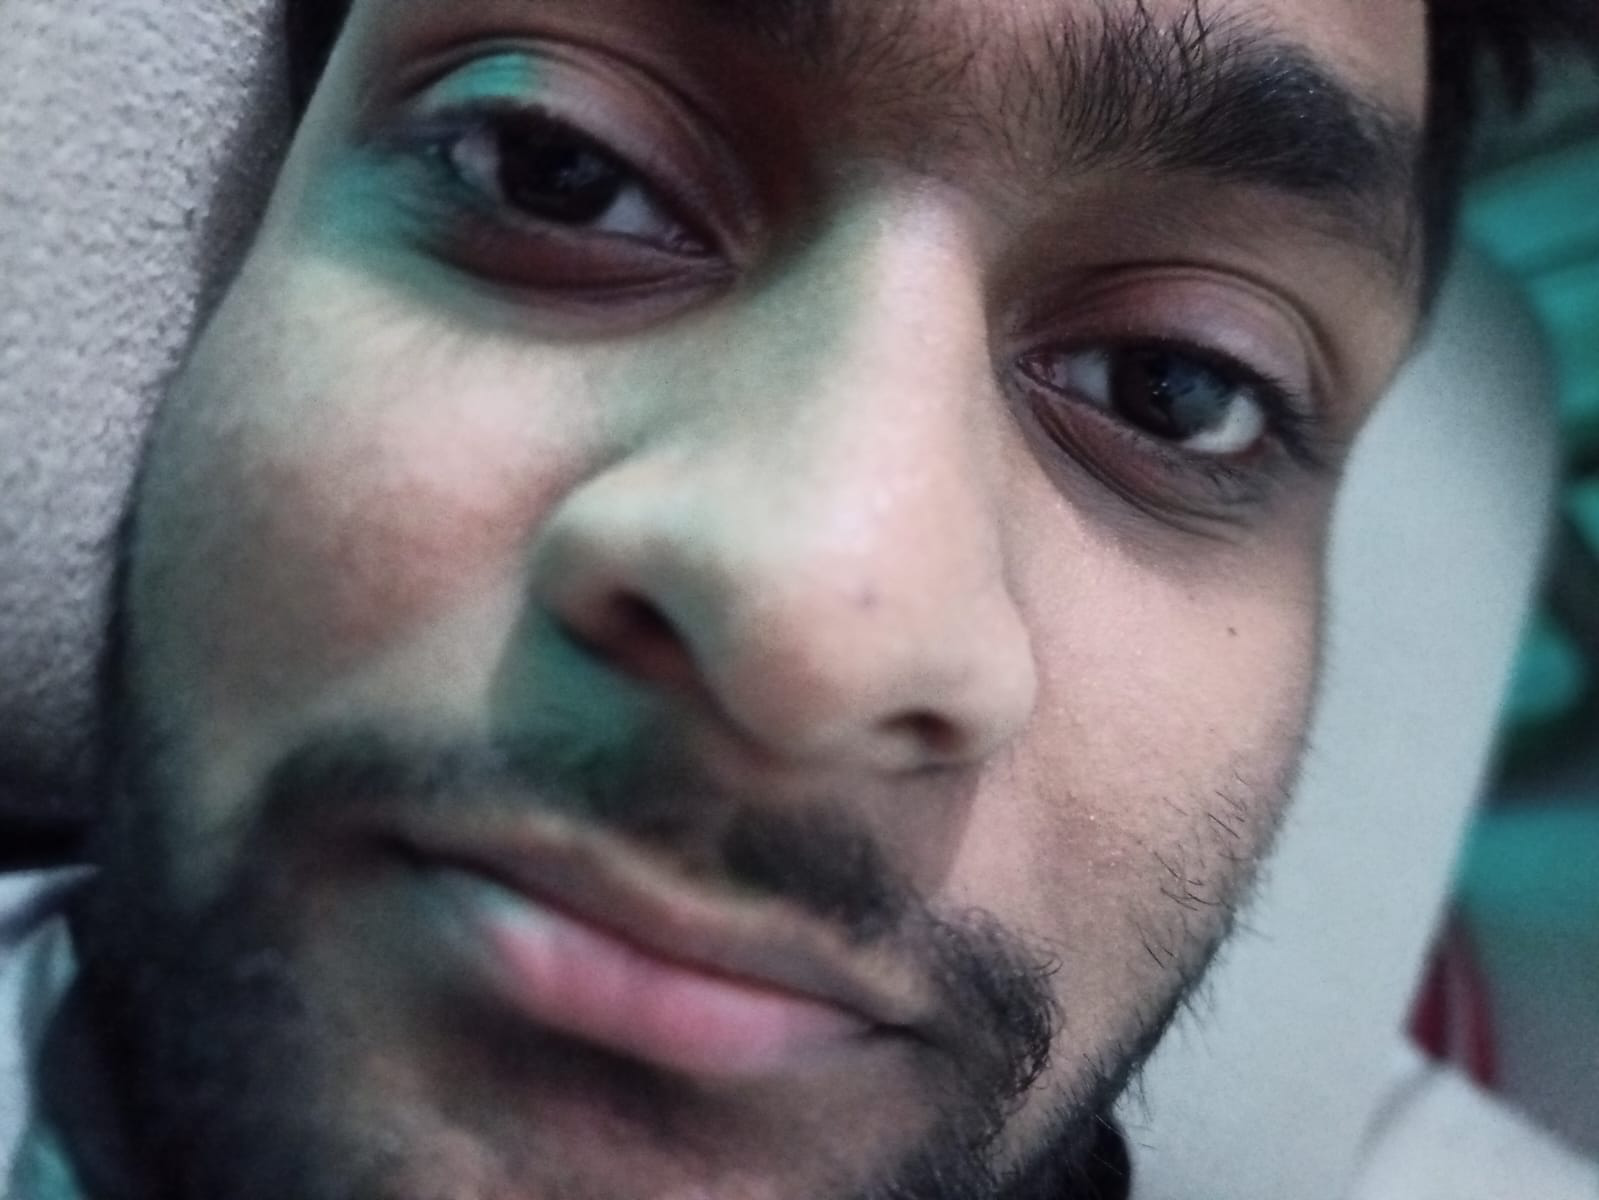

100%|██████████| 1/1 [00:00<00:00,  6.47it/s]




close up of a young man's face.
["close up of a young man's face.", "close - up of a young man's face.", "close - up of a young man's face looking at the camera.", "close up of a man's face.", "close - up of a young man's face looking at camera."]


In [49]:
#@title Inference

image = io.imread(UPLOADED_FILE)
pil_image = PIL.Image.fromarray(image)

#pil_img = Image(filename=UPLOADED_FILE)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)              # Encode image 
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

generated_text_prefix = generate_caption(model, tokenizer, embed=prefix_embed)          # Generate caption /
generated_text_prefix_bs = generate_beam(model, tokenizer, embed=prefix_embed)


print('\n')
print(generated_text_prefix)
print(generated_text_prefix_bs)